Scipy version in Kaggle is older than 1.12, needed for ShortTimeFFT.

- Band pass at the bottom.

In [ ]:
# !pip install --upgrade scipy

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import square, ShortTimeFFT
from scipy.signal.windows import gaussian

base_dir = "../../kaggle_data/hms"
# base_dir = "../../data/hms"
# base_dir = "/kaggle/input/hms-harmful-brain-activity-classification"


In [2]:
fs = 200  # Sample rate.

df_traincsv = pd.read_csv(f'{base_dir}/train.csv')
print(df_traincsv.shape)
df_traincsv.head()

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


In [3]:
eeg_id = 722738444
eeg_sub_id = 4

# eeg_id = 1327593077
# eeg_sub_id = 88

# eeg_id = 3988090520
# eeg_sub_id = 1

eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
print(eeg.shape)
eeg.head()

(14800, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-33.500000,-15.950000,27.120001,19.670000,10.10,18.610001,27.379999,-2.13,-16.750000,1.86,-3.19,-52.900002,-44.400002,25.790001,13.560000,-20.740000,-77.089996,-58.220001,-22.059999,-2.39
1,-30.570000,-12.760000,28.180000,21.530001,13.03,15.150000,27.379999,0.00,-15.680000,2.92,0.53,-52.369999,-44.930000,30.570000,22.330000,-21.799999,-70.180000,-48.650002,-18.340000,2.93
2,-34.029999,-18.610001,24.990000,15.420000,4.79,13.560000,22.059999,-5.05,-18.340000,0.53,-4.79,-55.830002,-48.910000,29.240000,25.790001,-19.940001,-62.740002,-46.790001,-22.330000,2.39
3,-32.430000,-18.610001,26.850000,19.139999,5.05,13.290000,24.190001,0.00,-19.940001,3.72,0.00,-55.029999,-47.590000,31.900000,34.029999,-11.170000,-53.700001,-39.610001,-16.219999,-3.46
4,-30.309999,-11.700000,34.029999,27.650000,13.56,21.270000,34.560001,10.37,-19.410000,8.24,8.77,-55.560001,-47.590000,32.959999,42.529999,-8.240000,-47.849998,-27.910000,-4.250000,0.00


In [4]:
# Missing values?
pd.isna(eeg).any(axis=None)

False

In [5]:
rec = df_traincsv.loc[(df_traincsv.eeg_id == eeg_id) & (df_traincsv.eeg_sub_id == eeg_sub_id)].iloc[0]
rec

eeg_id                               722738444
eeg_sub_id                                   4
eeg_label_offset_seconds                   8.0
spectrogram_id                          999431
spectrogram_sub_id                           4
spectrogram_label_offset_seconds           8.0
label_id                            1991146353
patient_id                               56885
expert_consensus                          LRDA
seizure_vote                                 0
lpd_vote                                     1
gpd_vote                                     0
lrda_vote                                   14
grda_vote                                    0
other_vote                                   1
Name: 15, dtype: object

In [17]:
# 50 second and center 10 second eeg sub samples 
offset = int(rec.eeg_label_offset_seconds)
start = offset * fs
end = (offset + 50) * fs
eeg_sub_50 = eeg[start:end]
start = (offset + 20) * fs
end = (offset + 30) * fs
eeg_sub_10 = eeg[start:end]

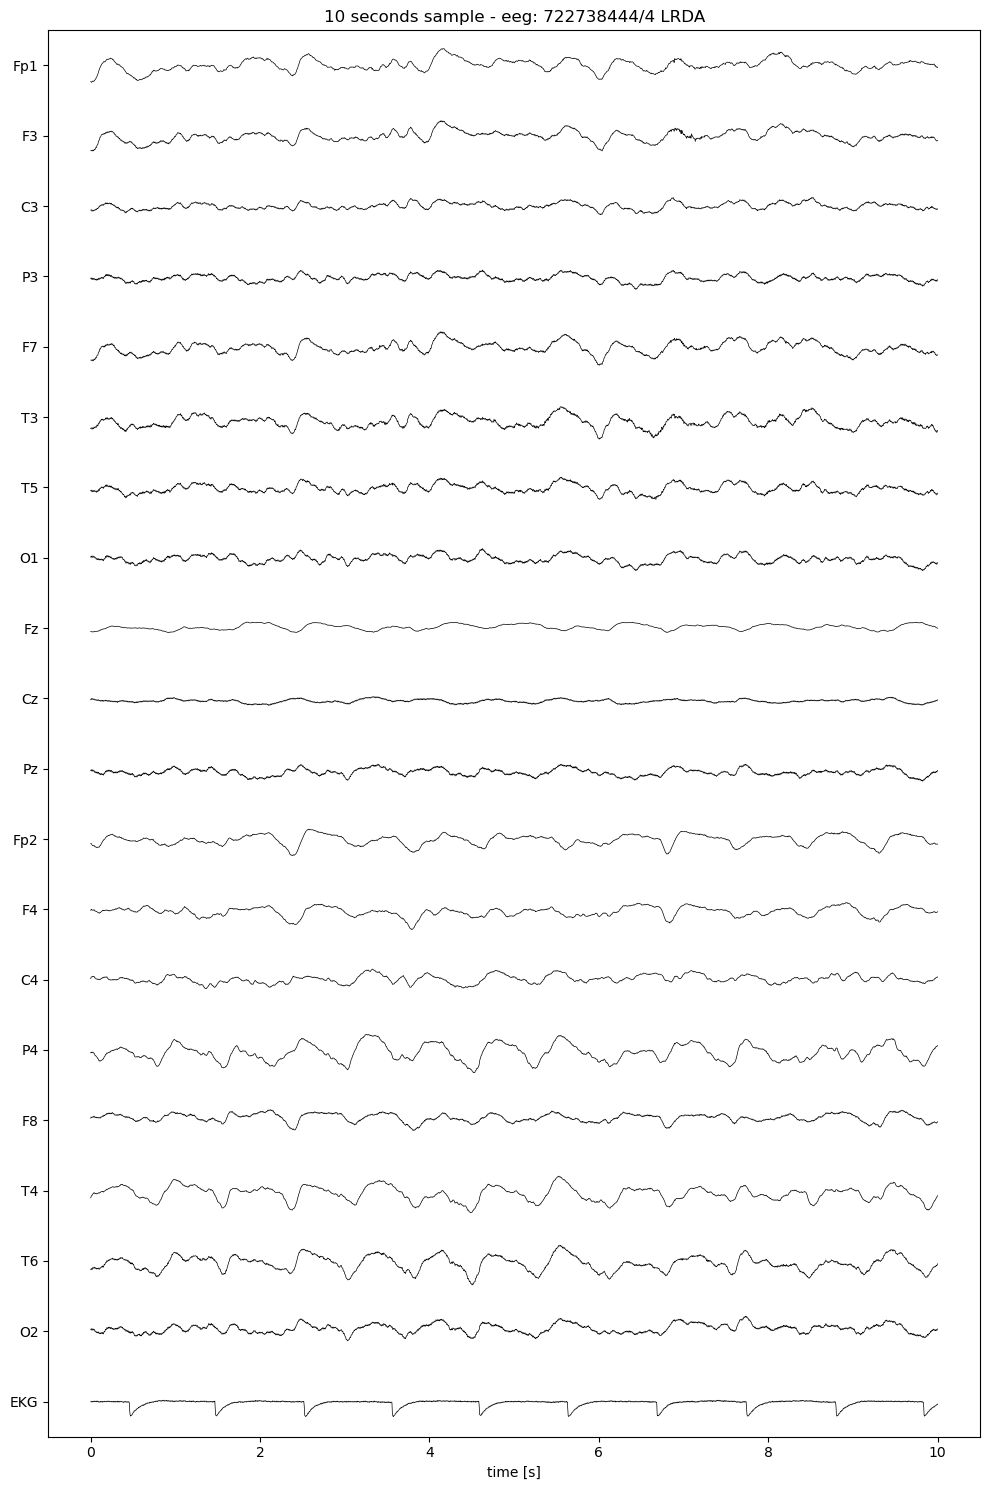

In [7]:
def plot_eeg(ax, eeg, title, sep):
    srate = 200 # Sample rate.
    nx = eeg.shape[0]
    totaltime = nx/srate
    X, Y = np.linspace(0, totaltime, nx), np.zeros(nx)
    yticklabels = eeg.columns[::-1]  # Reversed.

    for i, label in enumerate(yticklabels):
        Y = eeg[label]
        ax.plot(X, Y + (i * sep), linewidth=0.5, color='black')

    ax.set_title(title)
    ax.set(ylim=(-0.5*sep, (len(yticklabels)-0.5)*sep),
           yticks=np.arange(len(yticklabels))*sep,
           yticklabels=yticklabels)
    ax.set_xlabel('time [s]')

fig, ax = plt.subplots(1, 1, figsize=(10, 15))

plot_eeg(ax, eeg_sub_10, title='10 seconds sample - eeg: ' + str(rec.eeg_id)
          + '/' + str(rec.eeg_sub_id) + ' ' + rec.expert_consensus, sep = 500)

plt.tight_layout()
plt.show()

## Building Spectrogram

Only 50 seconds samples in test set.

In [9]:
eeg_sub_50

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
1600,21.270000,5.050000,6.110000,-11.430000,4.520000,-10.900000,-9.300000,-17.809999,17.809999,-10.10,-18.080000,23.389999,-10.630000,24.459999,28.440001,60.349998,9.300000,16.750000,14.620000,-13.83
1601,19.410000,7.440000,5.580000,-8.510000,7.180000,-13.560000,-7.980000,-13.820000,20.469999,-8.51,-14.360000,27.650000,-5.050000,25.250000,27.910000,58.750000,6.910000,17.010000,17.280001,-10.90
1602,14.360000,1.060000,-1.330000,-17.549999,-2.660000,-18.610001,-15.150000,-20.740000,19.410000,-13.56,-21.000000,26.049999,-7.180000,24.459999,25.250000,54.500000,3.460000,10.100000,9.570000,-7.71
1603,11.430000,-5.580000,-5.320000,-19.670000,-10.370000,-31.629999,-19.940001,-23.389999,19.410000,-12.23,-23.129999,28.180000,-2.660000,27.379999,25.790001,58.480000,5.850000,6.380000,7.980000,-12.23
1604,7.180000,-5.580000,-0.800000,-10.370000,-8.240000,-26.850000,-11.170000,-11.960000,21.270000,-6.65,-13.560000,30.309999,3.460000,32.959999,30.840000,59.810001,6.910000,15.150000,18.080000,-11.16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11595,96.500000,87.199997,67.790001,60.349998,91.980003,54.500000,83.470001,65.129997,-9.840000,-6.91,30.570000,-64.070000,-54.759998,0.000000,43.330002,28.440001,31.100000,81.879997,70.449997,-1.33
11596,97.559998,89.849998,68.050003,61.139999,95.699997,60.610001,86.400002,63.799999,-8.510000,-7.98,28.180000,-63.000000,-56.619999,2.920000,43.330002,26.320000,32.169998,80.809998,68.849998,3.72
11597,101.019997,86.930000,61.939999,48.910000,91.980003,54.500000,73.110001,51.040001,-8.770000,-14.09,17.809999,-64.070000,-60.880001,2.920000,39.880001,24.990000,32.959999,74.699997,57.689999,2.92
11598,101.019997,89.320000,63.799999,50.509998,97.300003,64.860001,78.160004,52.369999,-8.240000,-10.90,18.080000,-62.209999,-59.020000,7.180000,42.529999,31.370001,37.220001,74.699997,57.689999,-2.12


In [18]:
eeg_sub_10

,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
5600,-112.720001,-102.349998,-27.910000,-15.680000,-94.639999,-81.610001,-23.930000,5.050000,-24.719999,-10.630000,-14.090000,-32.959999,-6.910000,7.440000,-20.200001,15.150000,-51.570000,-62.740002,11.960000,-0.790000
5601,-116.699997,-103.940002,-25.790001,-10.630000,-94.110001,-76.559998,-18.610001,11.170000,-26.049999,-3.720000,-8.510000,-32.700001,-2.130000,16.219999,-16.480000,22.600000,-42.000000,-56.889999,17.280001,-2.920000
5602,-119.889999,-102.879997,-27.379999,-11.430000,-94.110001,-77.620003,-19.670000,11.170000,-25.250000,-1.860000,-7.710000,-34.290001,0.000000,20.740000,-15.420000,21.530001,-36.150002,-54.759998,17.549999,1.330000
5603,-115.639999,-107.400002,-36.150002,-22.330000,-99.959999,-85.330002,-31.370001,1.060000,-27.379999,-9.040000,-18.080000,-42.270000,-5.850000,19.139999,-21.000000,19.139999,-35.619999,-62.470001,6.650000,2.130000
5604,-114.309998,-107.930000,-34.560001,-20.469999,-99.690002,-85.599998,-30.309999,4.790000,-28.180000,-5.320000,-14.890000,-45.459999,-5.850000,21.530001,-18.340000,24.190001,-27.650000,-56.889999,9.300000,-2.930000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7595,-9.300000,-31.370001,-18.080000,-25.790001,-55.290001,-95.440002,-44.130001,-37.220001,3.720000,-13.560000,-19.940001,-35.619999,-21.799999,14.890000,23.389999,-16.480000,-56.619999,-34.029999,11.960000,-28.709999
7596,-12.760000,-34.290001,-19.670000,-26.850000,-59.279999,-99.690002,-44.130001,-38.009998,2.390000,-15.150000,-18.610001,-36.689999,-22.600000,16.219999,25.250000,-20.200001,-51.840000,-31.370001,11.960000,-22.600000
7597,-8.510000,-37.480000,-26.049999,-35.090000,-63.000000,-109.790001,-53.970001,-47.849998,1.060000,-17.809999,-24.990000,-36.950001,-21.799999,14.890000,23.660000,-18.080000,-47.590000,-35.360001,4.520000,-23.129999
7598,-10.630000,-32.959999,-21.799999,-28.180000,-57.950001,-100.489998,-45.990002,-39.080002,-0.530000,-12.230000,-17.010000,-36.950001,-18.870001,19.139999,28.709999,-10.900000,-39.080002,-25.520000,13.290000,-23.389999


In [19]:
N = eeg_sub_50.shape[0]
t_x = np.arange(N) * 1/fs  # time indexes for signal
print(t_x[-1])
t_x.shape

49.995


(10000,)

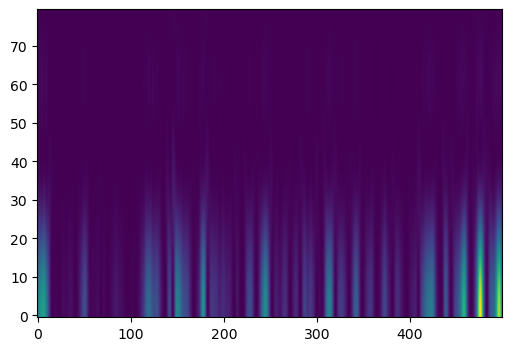

In [20]:
g_std = 16  # standard deviation for Gaussian window in samples
hop = 4  # 8
win_width = 19  # Pick an odd number.  49
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=800)
electrode = 0
x = eeg_sub_50.iloc[:,electrode].values
Sx = SFT.spectrogram(x)  # calculate absolute square of STFT

# dt = hop*1/fs
t0 = win_width/(2*hop)
# 10 second window
offset = rec.eeg_label_offset_seconds
ti = int((offset+20)*fs/hop + t0)
tf = int((offset+30)*fs/hop + t0)

n = int(20/SFT.delta_f)  # Number of bins below 20 Hz.
fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit

ax1.imshow(Sx[1:(n+1), ti:tf], origin='lower', aspect='auto')

plt.show()


Doing the spectrogram in a 10 second window.

In [21]:
N = eeg_sub_10.shape[0]
t_x = np.arange(N) * 1/fs  # time indexes for signal
print(t_x[-1])
t_x.shape

9.995


(2000,)

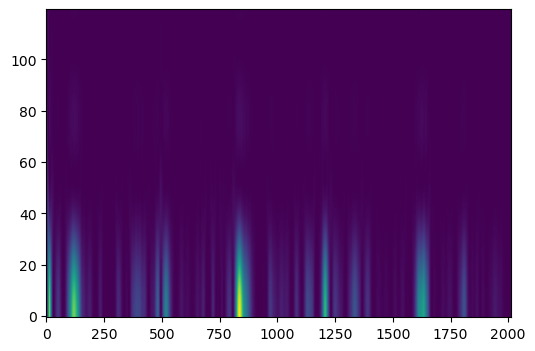

In [39]:
g_std = 16  # standard deviation for Gaussian window in samples
hop = 1  # 8
win_width = 15  # Pick an odd number.  49
win = gaussian(win_width, std=g_std, sym=True)  # symmetric Gaussian wind.
SFT = ShortTimeFFT(win, hop=hop, fs=fs, mfft=800)
electrode = 0
x = eeg_sub_10.iloc[:,electrode].values
Sx = SFT.spectrogram(x)  # calculate absolute square of STFT

# dt = hop*1/fs
t0 = win_width/(2*hop)
# 10 second window
# offset = rec.eeg_label_offset_seconds
ti = int(0)
# ti = int(t0)
tf = int(10*fs/hop)
# tf = int(10*fs/hop + t0)

n = int(30/SFT.delta_f)  # Number of bins below 20 Hz.
fig1, ax1 = plt.subplots(figsize=(6., 4.))  # enlarge plot a bit

# ax1.imshow(Sx[1:(n+1), ti:tf], origin='lower', aspect='auto')
ax1.imshow(Sx[1:(n+1)], origin='lower', aspect='auto')

plt.show()


In [40]:
Sx[1:(n+1)].shape

(120, 2014)

## What about observations in test set?

In [3]:
fs = 200  # Sample rate.

df_testcsv = pd.read_csv(f'{base_dir}/test.csv')
df_testcsv

,spectrogram_id,eeg_id,patient_id
0,853520,3911565283,6885


In [4]:
eeg = pd.read_parquet(f'{base_dir}/test_eegs/3911565283.parquet')
print(eeg.shape)
eeg.head()

(10000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,9.210000,-47.459999,15.100000,8.22,-16.900000,-22.99,-25.820000,-10.09,28.370001,-3.01,-27.299999,101.040001,35.110001,14.54,18.33,28.540001,44.090000,69.650002,30.74,171.679993
1,-3.590000,-30.290001,32.380001,10.80,-68.980003,-21.60,-15.080000,-9.21,26.360001,-8.98,-32.279999,95.800003,26.389999,4.82,10.54,20.559999,32.060001,59.439999,23.32,178.279999
2,-26.040001,-60.070000,2.370000,-10.15,-34.689999,-31.40,-31.920000,-26.98,-1.940000,-28.77,-49.770000,73.449997,-3.680000,-17.32,-16.15,-8.270000,5.330000,45.180000,9.49,306.739990
3,-3.040000,-36.250000,29.559999,14.53,-14.010000,-11.90,-14.230000,-6.31,26.040001,-2.77,-25.030001,91.010002,22.610001,6.90,9.93,15.480000,33.580002,69.620003,31.01,223.259995
4,-4.630000,-20.160000,25.190001,1.19,-44.580002,-23.51,-30.709999,-17.60,25.420000,-8.86,-33.959999,89.449997,19.440001,-2.08,6.11,8.380000,24.180000,55.869999,19.91,170.759995


## Band pass

In [ ]:
eeg_id = 1029863597
eeg_sub_id = 15  # seizure
# eeg_id = 3988090520
# eeg_sub_id = 1

eeg = pd.read_parquet(f'{base_dir}/train_eegs/{eeg_id}.parquet')
eeg = eeg.interpolate(limit_direction='both') # <<<<< Interpolation

print(eeg.shape)
eeg.head()

(38000, 20)


,Fp1,F3,C3,P3,F7,T3,T5,O1,Fz,Cz,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
0,-19.059999,-0.77,-21.08,-5.240000,-28.680000,6.260000,-9.48,-16.66,0.60,-0.86,1.91,1.360000,8.56,-7.16,-12.55,-12.56,-16.260000,-14.590000,-31.959999,30.940001
1,6.700000,10.80,-8.84,1.270000,-13.400000,7.380000,-4.11,-12.79,14.35,6.97,7.56,21.990000,19.17,-0.66,-9.55,-5.83,-13.180000,-16.040001,-29.830000,80.989998
2,-17.020000,-3.87,-31.00,-18.620001,-18.150000,-21.879999,-23.57,-24.91,-2.07,-9.34,-5.81,3.860000,7.87,-12.59,-21.10,-12.59,-10.480000,-25.290001,-38.820000,74.070000
3,-33.799999,11.40,-7.64,7.750000,-42.849998,24.540001,4.86,-6.96,7.27,7.58,13.32,7.960000,18.32,4.17,-8.18,-4.33,-6.870000,-25.700001,-27.120001,36.900002
4,-4.310000,14.77,-8.18,8.720000,-42.180000,16.780001,3.32,-9.30,13.11,9.78,14.55,18.190001,15.37,3.76,-3.55,-25.27,-25.870001,-5.720000,-26.160000,53.470001


In [ ]:
item = df_traincsv.loc[(df_traincsv.eeg_id == eeg_id) & (df_traincsv.eeg_sub_id == eeg_sub_id)].iloc[0]
item

eeg_id                              1029863597
eeg_sub_id                                  15
eeg_label_offset_seconds                 130.0
spectrogram_id                      1855162415
spectrogram_sub_id                          15
spectrogram_label_offset_seconds         130.0
label_id                            1713830727
patient_id                               54133
expert_consensus                       Seizure
seizure_vote                                 3
lpd_vote                                     0
gpd_vote                                     0
lrda_vote                                    0
grda_vote                                    0
other_vote                                   0
target                                     0.0
Name: 90985, dtype: object

In [ ]:
# 50 second and center 10 second eeg sub samples 
offset = int(item.eeg_label_offset_seconds)
start = offset * fs
end = (offset + 50) * fs
eeg_sub_50 = eeg[start:end]
start = (offset + 20) * fs
end = (offset + 30) * fs
eeg_sub_10 = eeg[start:end]

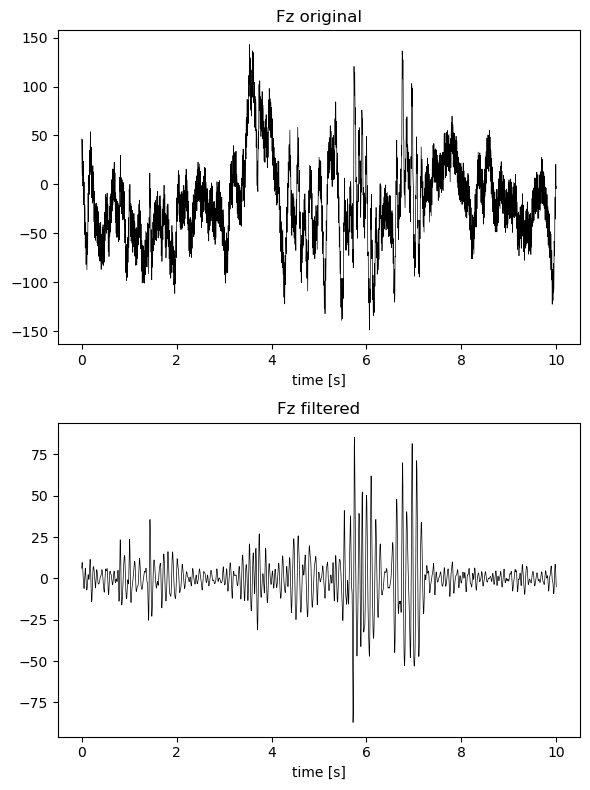

In [ ]:
i = 8

fig, ax = plt.subplots(2, 1, figsize=(6, 8))
nx = eeg_sub_10.shape[0]
totaltime = nx/fs
X, Y = np.linspace(0, totaltime, nx), np.zeros(nx)
yticklabels = eeg_sub_10.columns  # Reversed.
Y = eeg_sub_10[yticklabels[i]]

ax[0].plot(X, Y, linewidth=0.5, color='black')
ax[0].set_title(f'{yticklabels[i]} original')
ax[0].set_xlabel('time [s]')

# Filtering between 8 Hz and 30 Hz.
sos = butter(5, [8,30], btype='bandpass', fs=fs, output='sos')
filtered_data = sosfiltfilt(sos, eeg[yticklabels[i]])

start = (offset + 20) * fs
end = (offset + 30) * fs
filtered_data_sub_10 = filtered_data[start:end]

nx = filtered_data_sub_10.shape[0]
totaltime = nx/fs
X, Y = np.linspace(0, totaltime, nx), np.zeros(nx)
Y = filtered_data_sub_10

ax[1].plot(X, Y, linewidth=0.5, color='black')
ax[1].set_title(f'{yticklabels[i]} filtered')
ax[1].set_xlabel('time [s]')

plt.tight_layout()
plt.show()
